In [64]:
import torch
import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [65]:
# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
# https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html

# Set the model to evaluation mode
model.eval()

print("Model Loaded")

Model Loaded


In [69]:
def display_bounding_boxes(input_image: torch.Tensor, model_outputs: dict, thresh = 0.8):

    boxes = model_outputs[0]['boxes']
    cleaned_boxes = []
    for box in boxes:
        box = box.detach().numpy()
        box = box.astype(int)
        cleaned_boxes.append(box)

    scores = model_outputs[0]['scores']
    for i in range(len(scores)):
        if scores[i] < thresh:
            cleaned_boxes[i] = None
            
    cleaned_boxes = [box for box in cleaned_boxes if box is not None]

    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(input_image[0].permute(1, 2, 0))

    # Create a Rectangle patch for each cleaned box and add to the plot
    for box in cleaned_boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()
    

In [70]:
# Pass test_image.jpg thrpugh the model
image_path = '../data/test_image_2.jpg'
image = Image.open(image_path)
print(type(image))

# Dont need to normalize the input iamges, the pytorch model does it internally
tensor_transform = transforms.ToTensor()

# Apply the transformation to your image
normalized_image = tensor_transform(image).unsqueeze(0)

outputs = model(normalized_image)


<class 'PIL.JpegImagePlugin.JpegImageFile'>


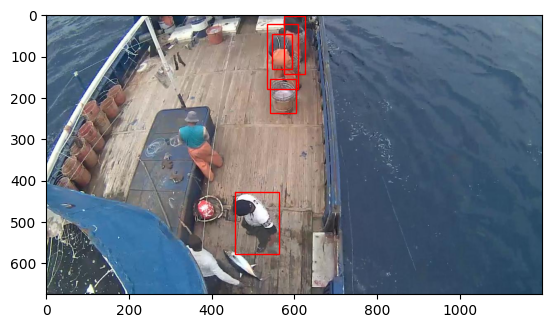

In [71]:
display_bounding_boxes(tensor_transform(image).unsqueeze(0), outputs, thresh=0.8)

In [60]:
def calc_iou(box1: list, box2: list):
    """
    Calculate the intersection over union (IoU) of two bounding boxes.

    Args:
        box1: list of floats (x_min, y_min, x_max, y_max)
        box2: list of floats (x_min, y_min, x_max, y_max)

    Returns:
        float: intersection over union (IoU) between box1 and box2
    """
    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # compute the IoU
    iou = intersection_area / union_area

    return iou
    


In [50]:
# Show all model layers
for name, param in model.named_parameters():
    print(name, param.size())

backbone.body.conv1.weight torch.Size([64, 3, 7, 7])
backbone.body.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
backbone.body.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
backbone.body.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
backbone.body.layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
backbone.body.layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
backbone.body.layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
backbone.body.layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
backbone.body.layer1.2.conv1.weight torch.Size([64, 256, 1, 1])
backbone.body.layer1.2.conv2.weight torch.Size([64, 64, 3, 3])
backbone.body.layer1.2.conv3.weight torch.Size([256, 64, 1, 1])
backbone.body.layer2.0.conv1.weight torch.Size([128, 256, 1, 1])
backbone.body.layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
backbone.body.layer2.0.conv3.weight torch.Size([512, 128, 1, 1])
backbone.body.layer2.0.downsample.0.weight torch.Size([512, 256, 1, 1])
backbone.body.layer2.1.conv1.weight t

In [51]:
# Freeze the model weights
for param in model.parameters():
    param.requires_grad = False

in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 28
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [52]:
outputs = model(normalized_image)

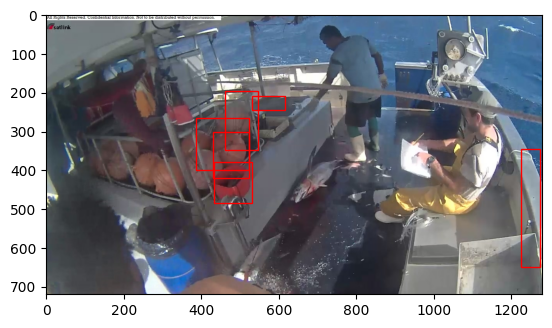

In [57]:
display_bounding_boxes(tensor_transform(image).unsqueeze(0), outputs, thresh=0.1)

In [59]:
model.train()
print("Model in training mode")

Model in training mode
